# ImpPres Baseline

This notebook illustrates how to use the DeBERTa-v3-base-mnli-fever-anli model to perform specialized inference on the ImpPres dataset.

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from evaluate import load, combine
import torch
import pandas as pd
from os.path import exists
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [32]:
label_names = ["entailment", "neutral", "contradiction"]
def evaluate(premise, hypothesis):
    input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
    output = model(input["input_ids"].to(device))
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    return prediction

In [33]:
evaluate("The weather is nice today.", "It is sunny outside.")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'entailment': 0.1, 'neutral': 99.8, 'contradiction': 0.0}

In [34]:
def get_prediction(pred_dict):
    if pred_dict["entailment"] > pred_dict["contradiction"]  and pred_dict["entailment"] > pred_dict["neutral"]:
        return "entailment"
    elif pred_dict["contradiction"] > pred_dict["entailment"] and pred_dict["contradiction"] > pred_dict["neutral"]:
        return "contradiction"
    else:
        return "neutral"

## Load ImpPres Dataset

In [35]:
from datasets import load_dataset,Dataset

if not exists('combined_imppres_presuppositions.parquet'):
    sections = ['presupposition_all_n_presupposition',
                'presupposition_both_presupposition',
                'presupposition_change_of_state',
                'presupposition_cleft_existence',
                'presupposition_cleft_uniqueness',
                'presupposition_only_presupposition',
                'presupposition_possessed_definites_existence',
                'presupposition_possessed_definites_uniqueness',
                'presupposition_question_presupposition']

    dataset = {}
    for section in sections:
        print(f"Loading dataset for section: {section}")
        dataset[section] = load_dataset("facebook/imppres", section)
    dataframes_list = []
    for set in dataset:
        for data in dataset:
            df = dataset[data].to_pandas()
            df['section'] = "presupposition_" + data
            dataframes_list.append(df)
    combined_df = pd.concat(dataframes_list, ignore_index=True)
else:
    combined_df = pd.read_parquet('combined_imppres_presuppositions.parquet')
grouped_df = combined_df.groupby("section")
print(f"loaded combined_imppres_presuppositions.parquet")
combined_df = {}
for sec, df_sec in grouped_df:
    combined_df[sec] = Dataset.from_pandas(df_sec)
dataset = combined_df

loaded combined_imppres_presuppositions.parquet


In [36]:
dataset

{'presupposition_all_n_presupposition': Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
     num_rows: 1900
 }),
 'presupposition_both_presupposition': Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
     num_rows: 1900
 }),
 'presupposition_change_of_state': Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
     num_rows: 1900
 }),
 'presupposition_cleft_existence': Dataset({
     features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
     num_rows: 1900
 }),
 'presupposition_cleft_

In [37]:
# Evaluate the model on the ImpPres dataset
from tqdm import tqdm
def evaluate_on_dataset(dataset):
    results = []
    label_names = ["entailment", "neutral", "contradiction"]
    for example in tqdm(dataset):
        premise = example['premise']
        hypothesis = example['hypothesis']
        prediction = evaluate(premise, hypothesis)
        results.append({
            'premise': premise,
            'hypothesis': hypothesis,
            'prediction': prediction,
            'pred_label': get_prediction(prediction),
            'gold_label': label_names[example['gold_label']],
        })
    return results

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [38]:
accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")

In [39]:
clf_metrics = combine(["accuracy", "f1", "precision", "recall"])

In [40]:
clf_metrics.compute(predictions=[0, 1, 0], references=[0, 1, 1])

{'accuracy': 0.6666666666666666,
 'f1': 0.6666666666666666,
 'precision': 1.0,
 'recall': 0.5}

## Your Turn

Compute the classification metrics on the baseline model on each section of the ImpPres dataset.

https://www.kaggle.com/code/faijanahamadkhan/llm-evaluation-framework-hugging-face provides good documentation on how to use the Huggingface evaluate library.

We will first run the model through the dataset:

In [44]:
# results = {}
# for section_name, section in dataset.items():
#     print(f"evaluating section:\t{section_name}")
#     results[section_name] = evaluate_on_dataset(section)
from concurrent.futures import ThreadPoolExecutor

def run_section(section_name, section):
    print(f"Evaluating {section_name}")
    return section_name, evaluate_on_dataset(section)

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(run_section, name, data) for name, data in dataset.items()]
    results = dict(f.result() for f in futures)


Evaluating presupposition_all_n_presupposition
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})
Evaluating presupposition_both_presupposition
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})
Evaluating presupposition_change_of_state
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})
Evaluating presupposition_cleft_existence
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})





  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 3/1900 [00:00<01:13, 25.93it/s]


  0%|          | 4/1900 [00:00<00:57, 32.77it/s]

  0%|          | 8/1900 [00:00<00:52, 35.72it/s]


  0%|          | 8/1900 [00:00<00:55, 34.16it/s]

  1%|          | 11/1900 [00:00<00:54, 34.37it/s]


  1%|          | 16/1900 [00:00<00:50, 36.96it/s]

  1%|          | 15/1900 [00:00<00:54, 34.79it/s]


  1%|          | 20/1900 [00:00<00:50, 36.88it/s]

  1%|          | 19/1900 [00:00<00:54, 34.68it/s]


  1%|          | 23/1900 [00:00<00:52, 35.71it/s]

  1%|          | 23/1900 [00:00<00:53, 34.81it/s]


  1%|▏         | 27/1900 [00:00<00:53, 34.78it/s]

  1%|▏         | 27/1900 [00:00<00:54, 34.11it/s]


  2%|▏         | 31/1900 [00:00<00:53, 34.83it/s]


  2%|▏         | 32/1900 [00:00<00:50, 36.69it/s]

  2%|▏         | 35/1900 [00:01<00:52, 35.29it/s]


  2%|▏         | 36/1900 [00:01<00:51, 36.26it/s]

  2%|▏         | 39/1900 [00:01<00:52, 35

Evaluating presupposition_cleft_uniqueness
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})




100%|█████████▉| 1898/1900 [00:58<00:00, 31.40it/s]


100%|█████████▉| 1892/1900 [00:58<00:00, 30.69it/s]

100%|██████████| 1900/1900 [00:58<00:00, 32.28it/s]


Evaluating presupposition_only_presupposition
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})



100%|█████████▉| 1891/1900 [00:58<00:00, 32.23it/s]


100%|█████████▉| 1896/1900 [00:58<00:00, 30.84it/s]

100%|█████████▉| 1895/1900 [00:59<00:00, 32.36it/s]

  1%|          | 12/1900 [00:00<00:58, 32.40it/s]


100%|██████████| 1900/1900 [00:59<00:00, 32.15it/s]


Evaluating presupposition_possessed_definites_existence
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})





100%|██████████| 1900/1900 [00:59<00:00, 32.11it/s]


Evaluating presupposition_possessed_definites_uniqueness
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})


  1%|          | 11/1900 [00:00<00:59, 31.71it/s]

  1%|          | 16/1900 [00:00<01:00, 30.95it/s]


  0%|          | 4/1900 [00:00<00:53, 35.14it/s]

  1%|          | 15/1900 [00:00<00:59, 31.91it/s]


  0%|          | 8/1900 [00:00<00:54, 34.75it/s]

  1%|▏         | 24/1900 [00:00<00:58, 32.32it/s]


  1%|          | 12/1900 [00:00<00:55, 34.22it/s]

  1%|▏         | 28/1900 [00:00<01:00, 30.89it/s]


  1%|          | 16/1900 [00:00<01:07, 27.93it/s]


  1%|          | 19/1900 [00:00<01:14, 25.35it/s]

  2%|▏         | 32/1900 [00:01<01:17, 23.97it/s]


  2%|▏         | 29/1900 [00:01<01:20, 23.37it/s]

  1%|          | 22/1900 [00:00<01:18, 24.04it/s]


  2%|▏         | 32/1900 [00:01<01:15, 24.70it/s]

  1%|▏         | 25/1900 [00:00<01:15, 24.79it/s]


  2%|▏         | 36/1900 [00:01<01:10, 26.38it/s]

  1%|▏         | 28/1900 [00:01<01:13, 25.50it/s]


  2%|▏         | 39/1900 [00:01<01:08, 27.03it/s]

  2%|▏         | 32/1900 [00:01<01:08, 27.20it/s]


  2%|▏         | 43/190

Evaluating presupposition_question_presupposition
Dataset({
    features: ['premise', 'hypothesis', 'trigger', 'trigger1', 'trigger2', 'presupposition', 'gold_label', 'UID', 'pairID', 'paradigmID', 'section', '__index_level_0__'],
    num_rows: 1900
})




 99%|█████████▉| 1885/1900 [01:01<00:00, 30.70it/s]


100%|█████████▉| 1894/1900 [01:01<00:00, 31.76it/s]

 99%|█████████▉| 1889/1900 [01:01<00:00, 30.41it/s]


100%|█████████▉| 1898/1900 [01:01<00:00, 30.09it/s]

100%|██████████| 1900/1900 [01:01<00:00, 30.70it/s]



 99%|█████████▉| 1889/1900 [01:01<00:00, 30.44it/s]

100%|█████████▉| 1898/1900 [01:01<00:00, 32.22it/s]A


100%|██████████| 1900/1900 [01:01<00:00, 30.77it/s]


  1%|          | 17/1900 [00:00<00:50, 37.44it/s]


100%|██████████| 1900/1900 [01:01<00:00, 30.68it/s]


  1%|▏         | 24/1900 [00:00<00:39, 47.55it/s]

  2%|▏         | 35/1900 [00:00<00:28, 65.99it/s]

  2%|▏         | 45/1900 [00:00<00:24, 75.69it/s]

  3%|▎         | 55/1900 [00:00<00:22, 82.83it/s]

  3%|▎         | 66/1900 [00:01<00:20, 89.15it/s]

  4%|▍         | 76/1900 [00:01<00:19, 92.22it/s]

  5%|▍         | 86/1900 [00:01<00:19, 92.60it/s]

  5%|▌         | 97/1900 [00:01<00:18, 95.17it/s]

  6%|▌         | 108/1900 [00:01<00:18, 97.31it/s]

 

We will now use the `evaluate` library to compute the classification metrics:

In [45]:
metric_prf = combine(["precision", "recall", "f1"])
acc = load("accuracy")
rows = []
all_preds, all_refs = [],[]
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
for sec, data in results.items():
    print(f"Computing metrics for section:\t{sec}")
    preds = [label2id[entry['pred_label']] for entry in data]
    refs = [label2id[entry['gold_label']] for entry in data]

    prf = metric_prf.compute(predictions=preds, references=refs, average="weighted")
    accuracy = acc.compute(predictions=preds, references=refs)["accuracy"]

    rows.append({"section": sec, "accuracy": accuracy, **prf})
    all_preds += preds
    all_refs += refs

overall_prf = metric_prf.compute(predictions=all_preds, references=all_refs, average="weighted")
overall_acc = acc.compute(predictions=all_preds, references=all_refs)["accuracy"]
rows.append({"section": "all", "accuracy": overall_acc, **overall_prf})

Computing metrics for section:	presupposition_all_n_presupposition
Computing metrics for section:	presupposition_both_presupposition
Computing metrics for section:	presupposition_change_of_state
Computing metrics for section:	presupposition_cleft_existence
Computing metrics for section:	presupposition_cleft_uniqueness
Computing metrics for section:	presupposition_only_presupposition
Computing metrics for section:	presupposition_possessed_definites_existence
Computing metrics for section:	presupposition_possessed_definites_uniqueness
Computing metrics for section:	presupposition_question_presupposition


### Results:

In [46]:
df = pd.DataFrame(rows)
display(df.set_index("section"))

,accuracy,precision,recall,f1
section,,,,
presupposition_all_n_presupposition,0.540526,0.514939,0.540526,0.512770
presupposition_both_presupposition,0.360526,0.312789,0.360526,0.329215
presupposition_change_of_state,0.414211,0.426000,0.414211,0.417228
presupposition_cleft_existence,0.686842,0.719960,0.686842,0.658489
presupposition_cleft_uniqueness,0.223158,0.218875,0.223158,0.217273
presupposition_only_presupposition,0.677895,0.711884,0.677895,0.658692
presupposition_possessed_definites_existence,0.768947,0.846793,0.768947,0.753304
presupposition_possessed_definites_uniqueness,0.399474,0.304671,0.399474,0.344534
presupposition_question_presupposition,0.715263,0.778503,0.715263,0.683899


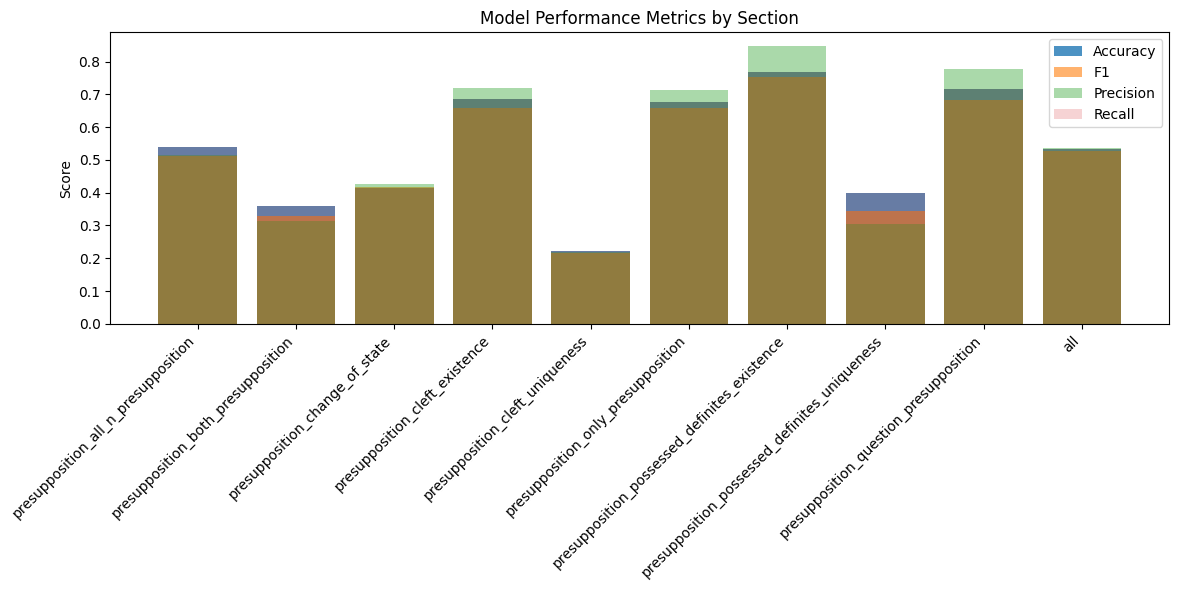

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.bar(df.index, df['accuracy'], alpha=0.8, label='Accuracy')
plt.bar(df.index, df['f1'], alpha=0.6, label='F1')
plt.bar(df.index, df['precision'], alpha=0.4, label='Precision')
plt.bar(df.index, df['recall'], alpha=0.2, label='Recall')

plt.xticks(ticks=df.index, labels=df['section'], rotation=45, ha='right')
plt.title('Model Performance Metrics by Section')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()
